In [598]:
import numpy as np
from scipy import special
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [599]:
def mixture_sampler(means, sigmas, p, size=1):
    sample = []
    for _ in range(size):
        i = np.random.choice(np.arange(len(p)), p=p)
        sample.append(np.random.normal(loc=means[i], scale=sigmas[i], size=1))
    return np.vstack(sample)
def U(X, means, sigmas, p):
    exp = torch.exp(-torch.cat([torch.pow(X - means[i], 2) / (2 * sigmas[i] ** 2) for i in range(len(means))], dim=1))
    coefs = p / (np.sqrt(2 * np.pi) * sigmas)
    return -torch.log(torch.matmul(exp, coefs))
def Pi_f(means, sigmas, p):
    return (p * (torch.pow(means, 3) + 3 * means * torch.pow(sigmas, 2))).sum().item()

In [600]:
p = torch.tensor([0.4, 0.6])
sigmas = torch.tensor([1., 1.])
means = torch.tensor([-1., 2.])

In [601]:
np.random.seed(42)
X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)
f_X = torch.pow(X, 3).squeeze()
pi_f = Pi_f(means, sigmas, p)
print(pi_f)

6.8000006675720215


In [602]:
x_l = torch.linspace(-6, 6, 1000).reshape(-1, 1)
u_l = U(x_l, means, sigmas, p)

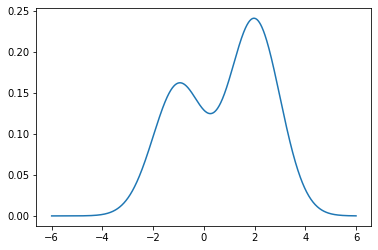

In [603]:
plt.plot(x_l.numpy(), torch.exp(-u_l));

In [604]:
device = 'cuda:0'
width = 16
fucking_network = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1),
)
fucking_network.to(device)
optimizer = torch.optim.Adam(fucking_network.parameters(), lr=3e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=2000, gamma=0.8)

In [605]:
n_epoch = 10000
Y = (f_X - torch.mean(f_X)).to(device)
loss = nn.MSELoss()
loss_history = []

In [606]:
for _ in tqdm_notebook(range(n_epoch)):
    phi_X = fucking_network(X.to(device)).squeeze()
    #phi_X_prime = torch.autograd.grad(phi_X.sum(), X, retain_graph=True)[0].squeeze()
    X.grad = None
    phi_X.to(device).sum().backward(retain_graph=True)
    phi_X_prime = X.grad.squeeze().to(device)
    U_X = U(X, means, sigmas, p).to(device)
    #U_X_prime = torch.autograd.grad(U_X.sum(), X, retain_graph=True)[0].squeeze()
    X.grad = None
    U_X.to(device).sum().backward(retain_graph=True)
    U_X_prime = X.grad.squeeze().to(device)
    g_X = -U_X_prime * phi_X + phi_X_prime
    Y_pred = (g_X - torch.mean(g_X)).to(device)
    train_loss = loss(Y_pred, Y).to(device)
    optimizer.zero_grad()
    train_loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    loss_history.append(train_loss.item())

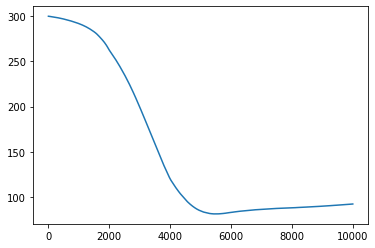

In [607]:
plt.plot(loss_history);

In [608]:
fucking_network.to('cpu').eval()
x = torch.tensor(np.linspace(-5, 5, 10001).reshape(-1, 1), dtype=torch.float32, requires_grad=True)
phi_x = fucking_network(x).squeeze()
x.grad = None
phi_x.sum().backward(retain_graph=True)
phi_x_prime = x.grad.squeeze()
U_x = U(x, means, sigmas, p)
x.grad = None
U_x.sum().backward(retain_graph=True)
U_x_prime = x.grad.squeeze()
g_x = -U_x_prime * phi_x + phi_x_prime
g_x_numpy = g_x.detach().numpy()
phi_x_numpy = phi_x.detach().numpy()
x_numpy = x.detach().numpy()

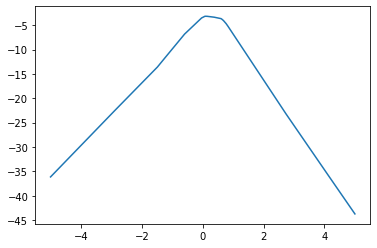

In [609]:
plt.plot(x_numpy, phi_x_numpy);

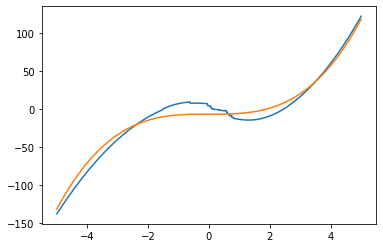

In [610]:
plt.plot(x_numpy, g_x_numpy)
f_numpy = x_numpy ** 3
plt.plot(x_numpy, f_numpy - pi_f);

In [611]:
estimates = []
vr_estimates = []
samples = []
fucking_network.eval()
device = 'cpu'
np.random.seed(42)
for i in tqdm_notebook(range(100)):
    X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)
    samples.append(X.detach().numpy())
    f_X = torch.pow(X, 3).squeeze()
    estimates.append(f_X.mean().item())
    phi_X = fucking_network(X.to(device)).squeeze()
    #phi_X_prime = torch.autograd.grad(phi_X.sum(), X, retain_graph=True)[0].squeeze()
    X.grad = None
    phi_X.to(device).sum().backward(retain_graph=True)
    phi_X_prime = X.grad.squeeze().to(device)
    U_X = U(X, means, sigmas, p).to(device)
    #U_X_prime = torch.autograd.grad(U_X.sum(), X, retain_graph=True)[0].squeeze()
    X.grad = None
    U_X.to(device).sum().backward(retain_graph=True)
    U_X_prime = X.grad.squeeze().to(device)
    g_X = -U_X_prime * phi_X + phi_X_prime
    vr_estimates.append((f_X-g_X).mean().item())

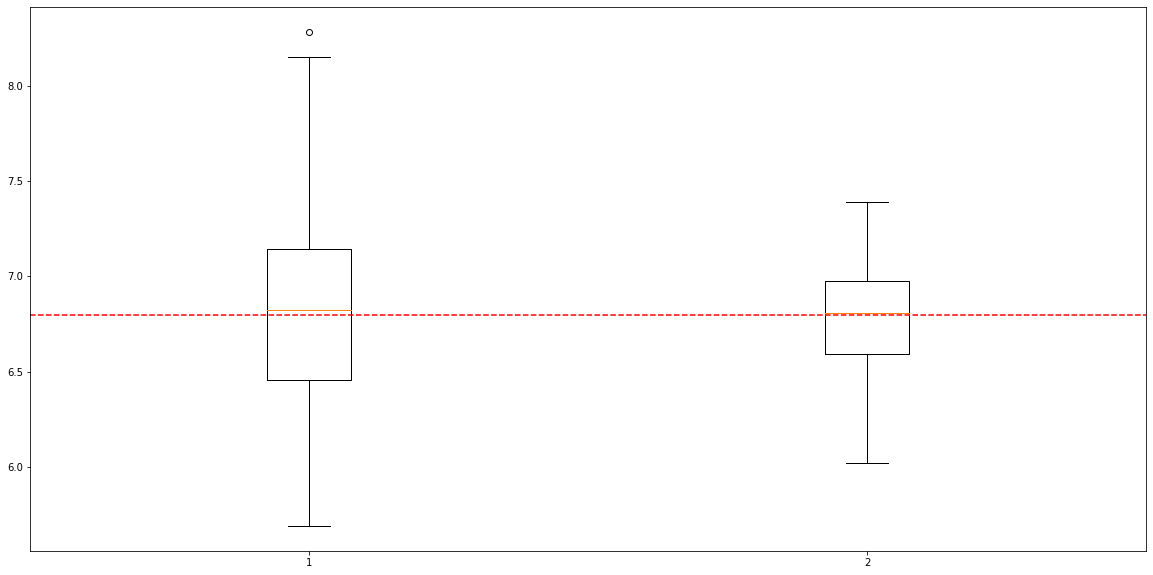

In [612]:
plt.figure(figsize=(20, 10))
plt.boxplot([estimates, vr_estimates])
plt.axhline(y=pi_f, color='r', linestyle='--');

In [613]:
print(np.var(estimates))

0.2656342186315964


In [614]:
print(np.var(vr_estimates))

0.08738121856853674


In [580]:
samples = np.array(samples)
np.save('sample3', samples)

In [ ]:
vanilla = np.array(estimates)
nn_vr = np.array(vr_estimates)

np.save('vanilla3', vanilla)
np.save('nn_vr3', nn_vr)

In [246]:
vanilla = np.load('vanilla3.npy')
nn_vr = np.load('nn_vr3.npy')

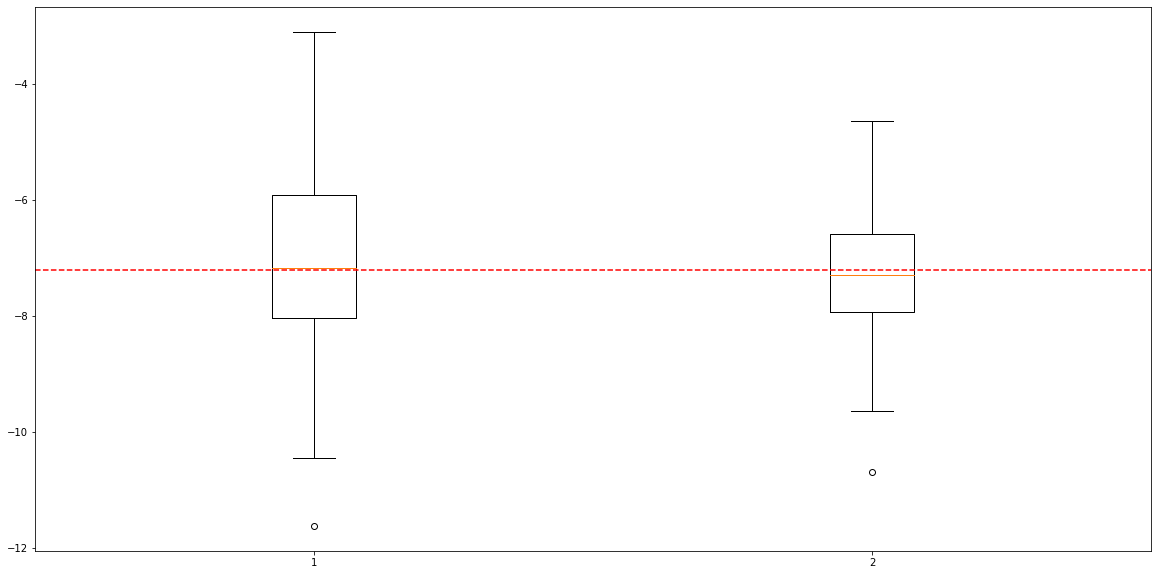

In [247]:
plt.figure(figsize=(20, 10))
plt.boxplot([vanilla, nn_vr])
plt.axhline(y=pi_f, color='r', linestyle='--');

## Manual check of the loss

In [439]:
device = 'cpu'
net = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1000, gamma=0.95)

In [440]:
U_X = U(X, means, sigmas, p)
X.grad = None
U_X.sum().backward(retain_graph=True)
U_X_prime = X.grad.squeeze().to(device)

n_epoch = 15000
Y = (f_X - torch.mean(f_X)).to(device)
loss = nn.MSELoss()
loss_history = []
X.grad = None

In [442]:
np.random.seed(42)
X = torch.tensor(mixture_sampler(means, sigmas, p.numpy(), 1000), dtype=torch.float32, requires_grad=True)
f_X = torch.pow(X, 3).squeeze()
pi_f = Pi_f(means, sigmas, p)
print(pi_f)

-15.200002670288086


In [443]:
for _ in tqdm_notebook(range(n_epoch)):
    phi_X = net(X.to(device)).squeeze()
    phi_X_prime = torch.matmul(net[2].weight, net[0].weight * (net[0](X) > 0.).T).squeeze()
    g_X = -U_X_prime * phi_X + phi_X_prime
    Y_pred = (g_X - torch.mean(g_X)).to(device)
    train_loss = loss(Y_pred, Y).to(device)
    optimizer.zero_grad()
    train_loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    loss_history.append(train_loss.item())

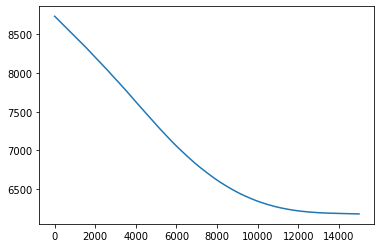

In [444]:
plt.plot(loss_history);

In [445]:
loss_history[-1]

6177.8388671875

In [446]:
net.to('cpu').eval()
x = torch.tensor(np.linspace(-5, 5, 10001).reshape(-1, 1), dtype=torch.float32, requires_grad=True)
U_x = U(x, means, sigmas, p)
x.grad = None
U_x.sum().backward(retain_graph=True)
U_x_prime = x.grad.squeeze().to(device)
phi_x = net(x.to(device)).squeeze()
phi_x_prime = torch.matmul(net[2].weight, net[0].weight * (net[0](x) > 0.).T).squeeze()
g_x = -U_x_prime * phi_x + phi_x_prime
g_x_numpy = g_x.detach().numpy()
phi_x_numpy = phi_x.detach().numpy()
x_numpy = x.detach().numpy()

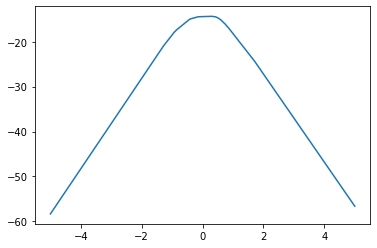

In [447]:
plt.plot(x_numpy, phi_x_numpy);

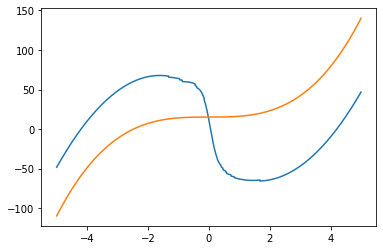

In [448]:
plt.plot(x_numpy, g_x_numpy)
f_numpy = x_numpy ** 3
plt.plot(x_numpy, f_numpy - pi_f);

In [133]:
estimates = []
vr_estimates = []
net.eval()
device = 'cpu'
np.random.seed(42)
for i in tqdm_notebook(range(100)):
    X = torch.tensor(mixture_sampler(means, sigmas, p, 1000), dtype=torch.float32, requires_grad=True)
    f_X = torch.pow(X, 3).squeeze()
    estimates.append(f_X.mean().item())
    U_X = U(X, means, sigmas, p)
    U_X.sum().backward(retain_graph=True)
    U_X_prime = X.grad.squeeze().to(device)
    phi_X = net(X.to(device)).squeeze()
    phi_X_prime = torch.matmul(net[2].weight, net[0].weight * (net[0](X) > 0.).T).squeeze()
    g_X = -U_X_prime * phi_X + phi_X_prime
    vr_estimates.append((f_X-g_X).mean().item())

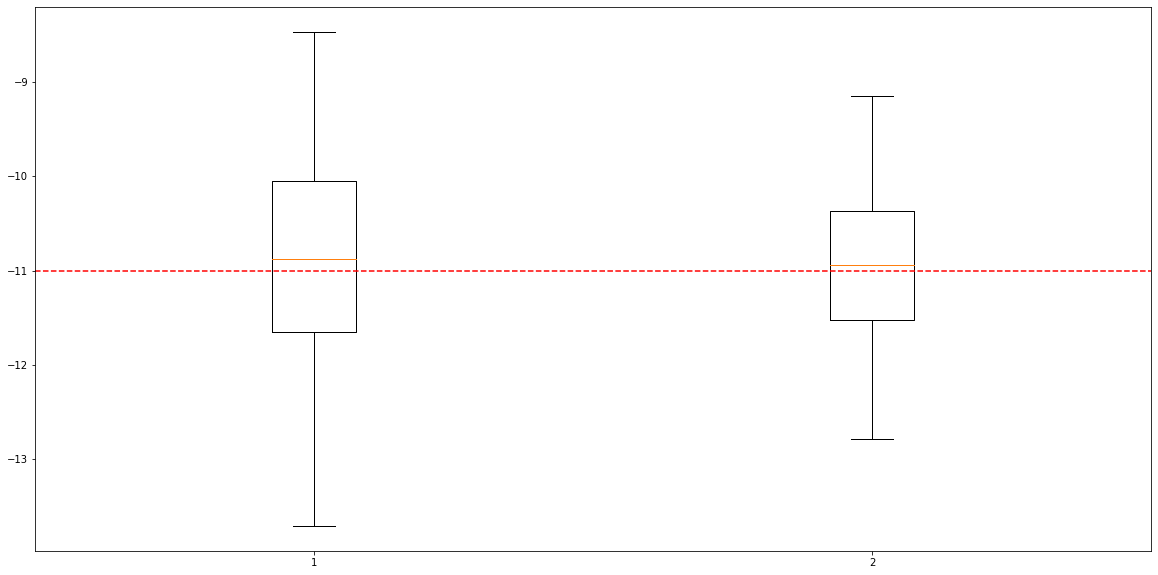

In [134]:
plt.figure(figsize=(20, 10))
plt.boxplot([estimates, vr_estimates])
plt.axhline(y=pi_f, color='r', linestyle='--');